In [6]:
import pickle
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler
import keras.backend as K
import keras
import tensorflow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import librosa
import librosa.display
import os 
import sys
%matplotlib inline

In [2]:
def loadData(id):

    with open(f'C:\\Users\\djaym7\\Desktop\\Github\\EmotionRecognition\\data_soundnet\\y_test_{id}','rb') as f:
        y_test=np.array(pickle.load(f))

    with open(f'C:\\Users\\djaym7\\Desktop\\Github\\EmotionRecognition\\data_soundnet\\X_train_{id}','rb') as f:
        X_train=np.array(pickle.load(f))
    with open(f'C:\\Users\\djaym7\\Desktop\\Github\\EmotionRecognition\\data_soundnet\\X_test_{id}','rb') as f:
        X_test = np.array(pickle.load(f))

    
    print(f'id : {id}')
    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    y_test = encoder.fit_transform(y_test)

    scalers = {}

    scalers = {}
    for k in range(X_train.shape[2]):
        scalers[k] = StandardScaler()
        X_train[:, k, :] = scalers[k].fit_transform(X_train[:, k, :])    
    for j in range(X_test.shape[2]):
        X_test[:, j, :] = scalers[j].transform(X_test[:, j, :])

   
    return X_test,y_test


In [3]:
X_test,y_test=loadData(1015)
print(X_test.shape,y_test.shape)

id : 1015
(82, 499, 13) (82, 6)


In [7]:
hid_post_act = 96
s0_t = np.zeros((X_test.shape[0], hid_post_act))
c0_t = np.zeros((X_test.shape[0], hid_post_act))
model = keras.models.load_model(r"C:\Users\djaym7\Desktop\Github\EmotionRecognition\data_soundnet"+f'/BI{1015}.h5')

TypeError: ('Keyword argument not understood:', 'time_major')

In [5]:
activations = []
inp = model.input
i_output = model.layers[8].output
fun = K.function(inp + [K.learning_phase()], [i_output])
out = fun([X_test,s0_t,c0_t])
out = np.array(out)
output = np.array(out).reshape(out.shape[1],out.shape[2],out.shape[3])
output

array([[[0.00168832],
        [0.00213624],
        [0.00449816],
        ...,
        [0.00130237],
        [0.00130237],
        [0.00130237]],

       [[0.00226573],
        [0.00177619],
        [0.00132142],
        ...,
        [0.00132142],
        [0.00132142],
        [0.00132142]],

       [[0.00202258],
        [0.00300887],
        [0.0028588 ],
        ...,
        [0.00123625],
        [0.00123625],
        [0.00123625]],

       ...,

       [[0.00178971],
        [0.00118799],
        [0.00397907],
        ...,
        [0.00118799],
        [0.00118799],
        [0.00118799]],

       [[0.0013426 ],
        [0.0013426 ],
        [0.0013426 ],
        ...,
        [0.0013426 ],
        [0.0013426 ],
        [0.0013426 ]],

       [[0.00235506],
        [0.00292323],
        [0.00245289],
        ...,
        [0.00135231],
        [0.00135231],
        [0.00135231]]], dtype=float32)

In [72]:
print(output[0].shape,X_test[0].shape)

(499, 1) (499, 13)


In [6]:
FileNames = []
labels = ['ANG','DIS','FEA','HAP','NEU','SAD']
yLabels = []
address=r'C:\Users\djaym7\Desktop\Github\EmotionRecognition\AudioWAV/'
total_num_people = []
for i in range(1,92):
    if i <10:
        total_num_people.append('100'+str(i))
    else:
        total_num_people.append('10'+str(i))
#create y
for i in os.listdir(address):
    for label in labels:
        if label in i:
            FileNames.append((i,label))
            #yLabels.append(label)


In [7]:
save=[]
for fname,_ in FileNames:
    for id in total_num_people:
        if id=='1015':
            if id in fname:
                #print(id,fname)
                save.append(fname)

In [8]:
sound_clip,sr=librosa.load(address+save[1])
max_size = 110361
sound_clip=np.pad(sound_clip,pad_width=(0,max_size-len(sound_clip)),mode='constant')
#sound_clip.shape=(110361,) #sr = 22050

In [18]:
from itertools import chain
indices=list(range(0,110361,220))
attenPlusSound=[]
atten_full = []
for i in range(499):
    atten_full.append((sound_clip[indices[i]:indices[i+1]]*0)+output[1][i])
    attenPlusSound.append(sound_clip[indices[i]:indices[i+1]]*output[1][i])
attenPlusSound = np.asarray(list(chain.from_iterable(attenPlusSound)))
atten_full = np.asarray(list(chain.from_iterable(atten_full)))


spectogram = librosa.amplitude_to_db(np.abs(librosa.stft(sound_clip)), ref=np.max)


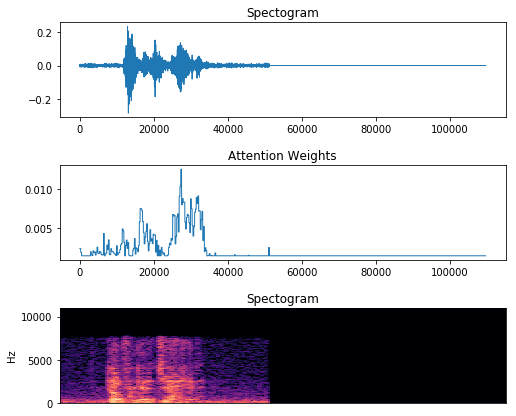

In [22]:
plt.figure(figsize=(8,7))
plt.subplots_adjust(hspace=0.5)
ax1=plt.subplot(3, 1, 1)
ax1.set_title('Spectogram')
ax1.plot(sound_clip[:109780],linewidth=1)
ax2 = plt.subplot(3, 1, 2)
ax2.set_title('Attention Weights')
ax2.plot(atten_full,linewidth=1)
plt.savefig('Attention_plot')
ax3=plt.subplot(3,1,3)
ax3.set_title('Spectogram')
librosa.display.specshow(spectogram, y_axis='linear',ax=ax3)
plt.savefig('Attention_plot')